This is the final project submitted for the course Optimal and Learning Control (ME-GY 7973), as done by Tarun Thathvik Paladugu. This project expands on the previous work on [Model Predictive Control](https://github.com/thathvik/optlearningcontrol/blob/master/Series3/Series_3_exercise_1.ipynb) of the LIPM in the Exercise Series 3. The instructions to run the same are given below.

# Final Project 

The code of the model is not modified. However the code modified and added are after the title Planning the walking Trajectory, with the implementation of Instantaneous Capture Point in the LIPM Simulation block. 

# Instructions

* All the Jupyter Cells should be run in order 
* To add perturbations, please change the variable perturbation for the magnitude of the perturbation and the inst variable to change the time at which the perturbation is applied. These variables are defined in the Run block.
* Can change the values of the desired velocity array, however, the maximum suggested velocity is 2 units/sec. However this is not capped by default inorder to observe the ability of the ICP to eventually stabilize the otherwise unstable behavior. (This motion cannot be stabilized by the MPC alone) (Can be capped by making cap = True, while calling the foot prediction function)

# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt 

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [2]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Animation and plotting utility

In [3]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[np.amin(x_real)-0.7,np.amax(x_real)+0.7], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([np.amin(x_real)-0.2,np.amax(x_real)+0.2],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=5)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    #for x com
    line, = ax.plot([], [], 'or', ms=4)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[6].set_data([XCom[i], XCom[i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [4]:
def plot_results(x_real, u_real, v):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    v[horizon_length-20:] = 0 
    
    plt.figure(figsize=[8,5])
    plt.plot(time[:horizon_length], x_real[1,:horizon_length], linewidth=2, label='Simulated CoM Vel')
    plt.plot(time[:horizon_length], v[:horizon_length], linewidth=2, label='Desired Velocity')
    plt.plot(time[:horizon_length], XCom_off, linewidth= 2, label = 'X_off')
#     plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=3, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=3, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=4, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], XCom, linewidth= 2, label = 'X_off')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
After readying the simulation of the model with the adaptation of Instantaneous capture point and online foot trajectory generation, implement the Model Predictive Control

## Simulation of the LIPM

In [5]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        self.max_step = 1.6
        self.min_step_time = 0.3
        self.min_step_t = int(self.min_step_time*10/(self.dt*10))
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        x[:,1] = self.next_state(x[:,0], u[:,0])
        factor = np.array([1, (self.z_com/self.g)**(0.5)])
        for i in range(horizon_length):
            
            XCom[i] = factor.dot(x[:,i])
            XCom_off[i] = XCom[i]-foot_steps[i]
            iterations_per_step = int(iter_per_step[i])

            if i < horizon_length-iterations_per_step and i > (self.min_step_t-1):
                next_foot_position = foot_steps[i+iterations_per_step]
                if foot_steps[i - self.min_step_t] == foot_steps[i]:
                    if XCom[i] > next_foot_position or XCom[i] < foot_steps[i]:
#                         print(XCom_off[i], XCom[i]-foot_steps[i])
                        if abs(XCom_off[i]) > self.max_step:
                            foot_steps[i:] = foot_steps[i] + np.sign(XCom_off[i])*self.max_step
#                             print(foot_steps[i] + np.sign(XCom_off[i])*self.max_step)
                        else:
                            foot_steps[i:] = XCom[i]
                        foot_steps = foot_predict(self, v, foot_steps, horizon_length, i)
                            
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                if i == inst:
                    disturbance = perturbation  #Suggested cap -4 and 4 during motion; However, this is different for different velocities
#                     print(disturbance)
                x[1,i+1] += disturbance
        return x, u

### Foot Position Generation

In [6]:
# Gait Generating
# need global variables: "step_freq", "step_time", "iter_per_step", "step_length" 

def foot_predict(model, v, foot_position, horizon_length, j=0, cap=False):
    max_step = 1.6
    for i in range(j, horizon_length-20):
        if v[i]>2 and cap:
            v[i] = 2 
        step_length[i] = v[i] #((v[i]*(model.z_com**0.67))/(0.8*((model.g/model.z_com)**.5)))#**(1/1.67)
        if step_length[i] > max_step:
            step_length[i] = max_step
        step_freq[i] = v[i]/step_length[i]
        step_time[i] = 1/step_freq[i]
        iter_per_step[i] = (step_time[i]/model.dt)
        if iter_per_step[i] < 5:
            iter_per_step[i] = 5
            step_time[i] = iter_per_step[i]*model.dt
            step_freq[i] = 1/ step_time[i]
            step_length[i] = v[i]/step_freq[i]
        if i+1 >= iter_per_step[i]:
            check_index = int(i+1-iter_per_step[i])
            if iter_per_step[i]%1 != 0:
                check_index += 1
                iter_per_step[i] +=1
            iter_per_step[i] = int(iter_per_step[i])
            if foot_position[check_index] == foot_position[i]:
                foot_position[i+1:] = foot_position[i] + step_length[i]
    return foot_position

Defining the variables required to simulate and implement the control

In [7]:
# first lets create a walking model
walking_model = LIPM()

horizon_length = 100

#initial conditions
x0 = np.array([0., 0.])
foot_position = np.zeros([horizon_length])
XCom = np.zeros([horizon_length])
XCom_off = np.zeros([horizon_length])

#other variables for trajectory generation
step_length = np.zeros([horizon_length])
step_freq = np.zeros([horizon_length])
step_time = np.zeros([horizon_length])
iter_per_step = np.zeros([horizon_length])

# now we create a vector that contains the desired velocity at every time step
v = np.ones([horizon_length])*1

v[30:60] = v[30:60]*1.5
v[60:] = v[60:]*2

#May try a different velocity array*

# for i in range(horizon_length):
#     v[i] = np.sin(i*0.2*np.pi)+1
# *Maintain the structure of the Velocity array

With the desired Velocity defined, run the next block to simulate the model with the controller

<IPython.core.display.Javascript object>


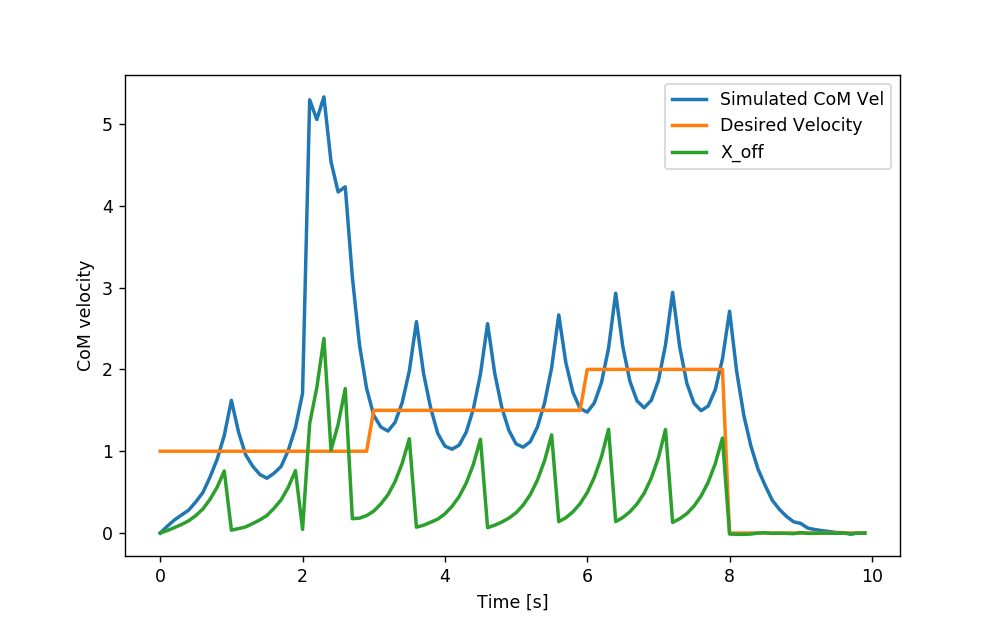

<IPython.core.display.Javascript object>


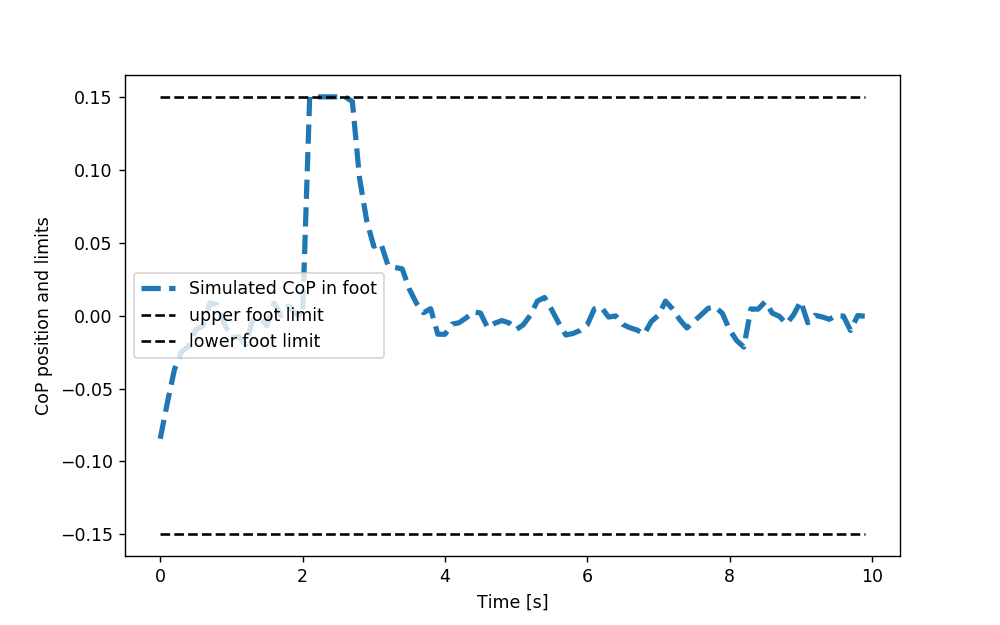

<IPython.core.display.Javascript object>


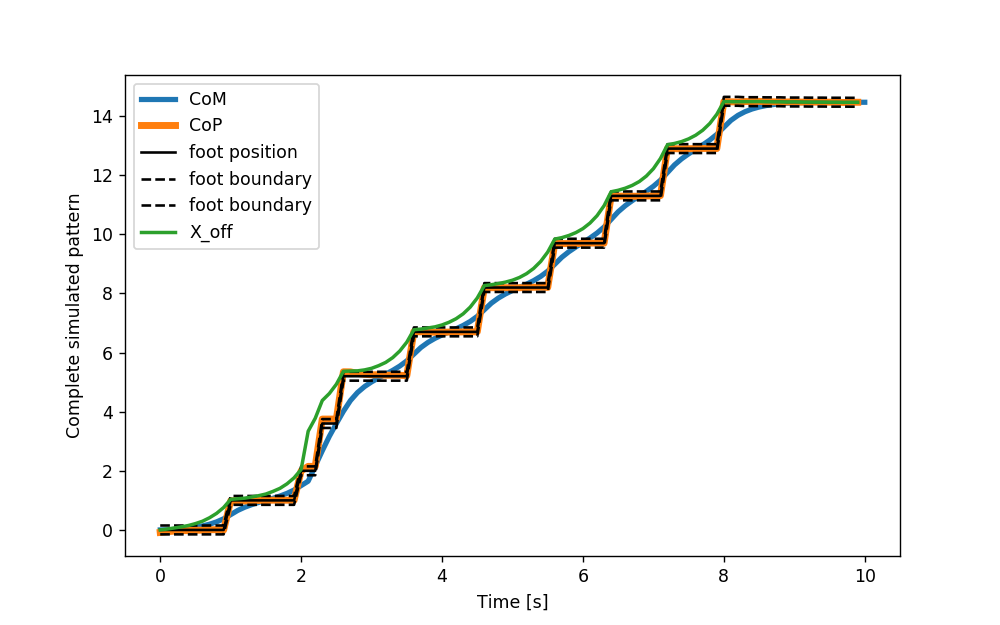

In [8]:
################
#  RUN BLOCK  #
###############


# A Trajectory with suggested foot position at every time step; this variable is subject to change on the go 
foot_position = foot_predict(walking_model, v, foot_position, horizon_length)

perturbation = 4
inst = 20

#for no perturbation uncomment the next line
# perturbation = 0

#Uncomment and run the next line to cap the maximum value of v
# foot_position = foot_predict(walking_model, v, foot_position, horizon_length, 0, cap = True)

#Defined the model predictive controller
def model_predictive_controller(x,i):
    
    #horizon length used for the controller 
    horizon_small = 30

    # we will define bounds of the form G_bounds [x u]^T < h_bounds
    G_bounds_new = []
    h_bounds_new = []
    # the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
    Q_new = []
    q_new = []
    R_new = []
    r_new = []
    
    for j in range(horizon_small):
        if i+j >= len(foot_position):
            current_foot_position = foot_position[len(foot_position)-1]
        else:
            current_foot_position = foot_position[i+j]
            
        Q_nominal_new = np.eye(2)
        Q_new.append(Q_nominal_new)
        # we want the CoM above the foot and 0 velocity
        q_new.append(Q_nominal_new.dot(np.array([[-current_foot_position],[0.]])))

        R_nominal_new = 100*np.eye(1)
        R_new.append(R_nominal_new)
        # we want the CoP in the center of the foot
        r_new.append(R_nominal_new.dot(np.array([-current_foot_position])))

        # we create bounds for the CoP location
        G_bounds_new.append(np.array([[0,0,1],[0,0,-1]]))
        h_bounds_new.append(np.array([[walking_model.foot_size + current_foot_position],[walking_model.foot_size-current_foot_position]]))

    # now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
    x_new_plan, u_new_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q_new,q_new,R_new,r_new,G_bounds_new,h_bounds_new, horizon_small, x)

    return u_new_plan[0,0]
    
# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, model_predictive_controller, horizon_length, foot_position, noise=True )

plot_results(x_real, u_real, v)

In [9]:
animate_walker(x_real, u_real, foot_position)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACH7G1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU4IHIyOTg0IDM3NTlmY2IgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABAuZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9FJprwo/OIxmeAS3WbdXpdKu0ByrJoa5YAsaZrX9re90gpSpiGL42yv6DCSvqvg
azyI+KsnO+nA+JkL9BJ4g3D0lmyQhzGoDsYcskKPQY6UsJ8tgttiYcekBCOT3RSMRaUIwT++Ubet
S+W2uM2qedjNB+8zrBXmT3c7ZpXepyIRz3DDB256pri4UJxfCeTtcM7TeY3KDJ2pSg3xZ7rKPOWM
EoE5ya6pWlPPVquvMvk5ixuN3EaXvlMeXOivZY00LeR56zM8eM8TE3g8ejSolJKPCfF9XORtBcNu
2ATebR7Z4WD+f202EtfwuTMJQP0AkmUWBbQZpzmwlS0oH/VJlIWXd+8PZLS6ycJoDgfaGWXSgghV
bRFeQQjWreUDorC3/Bg9hIwV+4N47LljTwBjufTiLB+Kgdqn5XDHlllncggcAEzr+sF6vQMxKtAW
hf31mtjUBZbuUev2SP+s2/I8idIdrewJBrv4yJ6f9LvcUFw3pPFnV7bDd+QrJvVWD58BlGVaB3YV
U44eWJ5/x9bcIgZDfO39R6RTp4/BRbB/MrVwHAX/kzHVbEoqFxlNLd+aaSMptpbcD37cr3qYJBOg
w85Ruh6g/dKAvAJIkvc4Q9olr5tnD5nBD4C4LsRFsC9fA/7L+YzJZvjqlK/Fhbyc/23ORsc8PYor
Nfhrk6U5bqqaY5Sc7ZqpC+yXXj210kQOjYTNvJl9iTOLCki7DIk1z7gRYW9fL6l22tEJ2bRQX1El
8IrM3s1JOKMfw3XfjNXUTRiWASTJWQe1wuOGC6scJ0ygn08pOjW2P4GNNseQ/LfVDavjMnVSICdd
PJkkm0XKMXm20XOn1hb5w83stifRgxmEIbkNO/5/b4arpwAUuzXFi0xX3XEubGJZTwunXbudyJ8Z
SSFxgWk1UpC5q9avoBGVlupVDTzgsBeR6Hx0q382M9pt7afev60PHY6fvPOqBVwqAbtLDGBII54s
LZ6rwW6Ujp2aCsWJUNuvtVq1/PqU+rZ8zzrmrs0OFdzgbab4D7byksSjxv3ogo59gMIO4yEXyMpr
Vcey/CQEeuiGMbwI4uHlpe+IwDe47gAAZi9FTCUWA6AAAAYaJ0heh6c6pTFP2CSoMzFosiB0w0oI
Olb+SncjCFMafS+PUF/Cz7UXtxJPGlYtA41hTGxTa7QQLCM8N7llX/3TowYL+qObuR/9/QsNlxTi
DOyJ6j7BVDb9D1GhrF4eeq8xppA9biIM2sKQA6QY9+XFV72XrTJ0PvWk77ZETky/tOg4dC1xIy0n
cv6csWXYBGsr1TzmeAZ4VI/cNWVEr4elfRBi0ZcdpwZnbXEKAQB8FdSAp94ai/mkuCb6XJI9tCIE
rqHAbX22mx4cmDUqjNQeY/nDI2txGVc3D5GGbTLnugxGLy3OgMAyk5h4uWsdSPbiJ3f7kffic3n7
GcE7t7Glt2M/PhPmvkf1M6MNnRWVRFa07JZPYSAn/BMlV0o5V38d/AvIO47ZeCJ/P069vW2aE9l9
Sw3AmwukqpP79ePexy8XRu1ssE3uF3DNGIgY1/zywKAzZdbir8ZlnEon0bonbtrnegSmI32xKbpC
tTUtvLN65xuyETEwz/wgSWS2N8fQ7Fdb3STujfpuWECPB3Xcsht6U4O5fCXd4SaQ2FLaedJaA85c
Ai0wNR9ot7bLJ9uLgPgvaORbs4NbwhISGuAaVZ5LlOgAAAMAA1mhDwxVwj/bU+yLiC2KoUsycQbQ
O6IgTeRcfMVsEo/XFSuLV7hjRAMdQqQUrNAp4sV/s0mxnVcuLZlVtl+gBEvOSvF9BoIj8V2XXDVE
1Ek0JxwR3tqHhZes7oLeLHV3vOdfK3LjEprp1dNhwWmJd0s2o//6QVD1xzQSq3UlMItf8LU9XQtX
3mfAdZHeW25VaX8iuj/4OlZYQveDMM6m0dAOUR0ORdrV8AXQsbhWLKoWg2KHyDkw10Rg+ZXXFLQs
VQjw4AaKjfylBi2Lt4kh4z/Je1ZitQLeWlvnC/+nPdlM4cKskCVWBtsNOCrZVXcXsFXzZSiPhoIz
AEa92PwVMXT9rP5pZx2gifxRiMfC299f1R4HKMta0fKY99xtmFHcpqAOWfatgQbDBOZi7HeAxYts
vdJH/ef1EDM9+ZHOnMSLAoJ/1naUkOa99GX6GquJHG+jLwHYo6BFY8PDX6ZFc3KV99uwQY4qUR/9
lhnKus3UiJaHRf8802ydMs5D8l8aTSvrkvjjdH6x76nAat4ST7yDhdkjPkyAx1b3jHZnzn1f8JVB
g721q1lBs5zo6iI80BeNwgh3I8a41DAUgwcVrjfQ7M1HrGTQyUyBu5vi4RozagWFZO7Y1YBDTmPx
I7c2Y9g+7AVZTfPOFB0BDmOpl8lzJ1my5eToPLtpwcW/081NON/X+WlAQ4KT7BbvnE8s2QF5qlE6
gELp4xISVz5M6a4k3xJ5iPtepzMq64eiltO0/8UmpdH7WfpehR3JtwM9gGhID33Xf3l/lcfTQs+m
LPEFKBNBiVRUAw20V23vUQq9NQRVzgAAQwGfrF5Tj2K5j+larOLo+8nJDjHqDQqLM4qsKp2fOt4G
E1LEcxlF8B1isCRt2up8ZuF287Ao/Kf15v6yQi+bYwJcf2Vhw1xfDxPK+sY1TvtwesQLhLpDv2Qg
kyonj/05bj99H07rLb/DjfUd3+dTd7SW6Ft/oMNJmmQa1l/CLCLzBfpLmbvtYvH+lgQEyg02XaIV
TrFcxVPs2DPM/0GmKNRqhA56xOqO/x98BybQ/RSXvAVWR2tQbuEzqh/smTLhvI+iHSOrXEmJkQQX
4x32+M4jBxBjdqOMCP4y3